#HW1 - Clinical Trials Analytics in PySpark

### 1. Spark Installation


Download and install Spark with all its dependencies

In [ ]:
#Install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# download spark3.4.4
#!wget -q https://apache.osuosl.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz

# unzip it
!tar xf spark-3.4.4-bin-hadoop3.tgz

# install findspark
!pip install -q findspark

It's necessary to add enviroment variables to make visible runtime Spark to linux enviroment. We could install different versions of spark and decide later which one we would use.

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"

You import the library `findspark` that allow to find and automatically initialize Spark configuration without having to manually configure enviroment variable and other options

In [ ]:
import findspark
findspark.init()

# Spark version verification on cluster
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate()

assert "3." in sc.version, "Verify that the cluster Spark's version is 3.x"

In [ ]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

### 2. Loading the Dataset on Spark


RDD is a data representation in Spark, but for simplicity of coding and design, it became necessary to introduce a new, more responsive data model.

Spark SQL came to live, it offers to the users the opportunity ot use datasets/dataframes. They are objects tablelike: each column has a name and a type, each row is a combination of column values

The SQL engine on Spark translates sql-like operations in RDDs and gives at the end a RDD with the results.

In [ ]:
# Libraries for SQL Spark
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import split, explode, trim, count, sum, col, current_date, lower, regexp_replace
import time

spark = SparkSession(sc)
print(spark)

In [ ]:
import zipfile
import requests

# Download the zip file from GitHub
url = "https://github.com/Salvr28/Big-Data-Homeworks/raw/main/Data/dimensions_clinicalTrials.zip"
zip_path = "dimensions_clinicalTrials.zip"

r = requests.get(url)
with open(zip_path, 'wb') as f:
  f.write(r.content)

# Extract the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(".")

# Read the CSV
extracted_files = os.listdir("./")
print("Extracted files:", extracted_files)

csvPath = "./dimensions_clinicalTrials.csv"

Extracted files: ['.config', 'spark-3.4.4-bin-hadoop3', 'dimensions_clinicalTrials.zip', 'spark-3.4.4-bin-hadoop3.tgz', 'dimensions_clinicalTrials.csv', 'sample_data']


In [ ]:
print(csvPath)

./dimensions_clinicalTrials.csv


In [ ]:
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')

# Percorso base per i notebooks Colab
base_path = '/content/drive/MyDrive/Colab Notebooks'

# Percorso completo per la cartella Big Data
big_data_path = os.path.join(base_path, 'Big Data')

# Verifica se la cartella Big Data esiste, altrimenti creala
if not os.path.exists(big_data_path):
    os.makedirs(big_data_path)
    print(f"Directory created: {big_data_path}")
else:
    print(f"The directory already exists: {big_data_path}")
    # Prova a stampare il contenuto se la cartella esiste
    try:
        print("Big Data directory contents:")
        print(os.listdir(big_data_path))
    except:
        print("Unable to read the directory contents")

# Percorso per Homework 1
homework1Path = os.path.join(big_data_path, "Homework 1")

# Verifica se la cartella Homework 1 esiste, altrimenti creala
if not os.path.exists(homework1Path):
    os.makedirs(homework1Path)
    print(f"Directory created: {homework1Path}")
else:
    print(f"The directory already exists: {homework1Path}")

Mounted at /content/drive
The directory already exists: /content/drive/MyDrive/Colab Notebooks/Big Data
Big Data directory contents:
['Homework 1']
The directory already exists: /content/drive/MyDrive/Colab Notebooks/Big Data/Homework 1


### Dataset Object Creation

Create the Dataset Object with the spark Object `read`

In [ ]:
# Indentifies types for each column (float, integer, string, etc)
# Gets columns names of the first csv's row
ctDS = spark.read \
  .option("inferSchema", "true") \
  .option("header", "true") \
  .option("multiline", "true") \
  .option("quote", "\"") \
  .option("escape", "\"") \
  .csv(csvPath)

# Print the schema
ctDS.printSchema()

root
 |-- Rank: integer (nullable = true)
 |-- Trial ID: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Brief title: string (nullable = true)
 |-- Acronym: string (nullable = true)
 |-- Abstract: string (nullable = true)
 |-- Start date: date (nullable = true)
 |-- Start Year: double (nullable = true)
 |-- End Date: date (nullable = true)
 |-- Completion Year: double (nullable = true)
 |-- Phase: string (nullable = true)
 |-- Study Type: string (nullable = true)
 |-- Study Design: string (nullable = true)
 |-- Conditions: string (nullable = true)
 |-- Recruitment Status: string (nullable = true)
 |-- Number of Participants: double (nullable = true)
 |-- Intervention: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Registry: string (nullable = true)
 |-- Investigators/Contacts: string (nullable = true)
 |-- Sponsors/Collaborators: string (nullable = true)
 |-- City of Sponsor/Collaborator: string (nullable = true

In [ ]:
# Let's print some rows
ctDS.select("Study Design").show(20, truncate = False)

+----------------------------------------------------------------------------------------------------------------------------+
|Study Design                                                                                                                |
+----------------------------------------------------------------------------------------------------------------------------+
|Allocation: Randomized; Intervention Model: Parallel Assignment; Masking: None (Open Label); Primary Purpose: Treatment     |
|Allocation: N/A; Intervention Model: Single Group Assignment; Masking: None (Open Label); Primary Purpose: Supportive Care  |
|Allocation: Randomised Controlled Trial; Primary Purpose: Treatment                                                         |
|Allocation: Randomized; Intervention Model: Parallel Assignment; Masking: Double; Primary Purpose: Treatment                |
|Observational Model: Cohort                                                                                   

### 3. Preprocessing


At a first sight it could not be clear, but in this dataset there are a lot of duplicate rows. Clean the dataset with dropDuplicates()



In [ ]:
# Dirty Dataset
count_dirty = ctDS.count()

# Cleaned Dataset
#ctDS = ctDS.fillna("NA_TEMP")
ctDS = ctDS.dropDuplicates(["Trial ID"])
#ctDS = ctDS.replace("NA_TEMP", None)
count_clean = ctDS.count()

print("Dirty: " + str(count_dirty))
print("Clean: " + str(count_clean))


Dirty: 15990
Clean: 8356


In [ ]:
# Before the cleaning there were 7 rows with this "title"
ctDS.select("*").where(ctDS["Title"] == "Phase III Study on STem cElls Mobilization in Acute Myocardial Infarction").show(20,truncate=False)

+----+-----------+-------------------------------------------------------------------------+--------------------------------------------------------------------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

There's still something wrong...Some columns have pseudo-structured data, like dictionaries and lists. In particular:

**Dictionaries**

*   Study Design

**Lists**

*   Conditions
*   Investigators/Contacts
*   Sponsors/Collaborators
*   City of Sponsor/Collaborator
*   State of Sponsor/Collaborator
*   Country of Sponsor/Collaborator
*   Fields of Research (ANZSRC 2020)
*   Collaborating Funders
*   Funder Group
*   Funder Country
*   RCDC Categories
*   HRCS HC Categories
*   HRCS RAC Categories
*   Cancer Types
*   CSO Categories

**List of two elements**

*   Age (min ; max)

For better analytics, we have changed manually the type of these columns with a preprocessing script.



---



The first transformation involves **preprocessing the pseudo-lists**.
1. A list named `columnsList` is defined, containing the names of all columns to be processed (these columns contain data delimited by ";").
2. For each column in the list, the PySpark `withColumn()` method is used to replace the original column with a transformed version.
3. The transformation is performed using the `expr()` function, which splits the string into an array using the ";" delimiter and applies a transformation function. This function removes extra whitespace with `trim(x)` and converts any empty strings to `NULL` values for each element in the array.



In [ ]:
from pyspark.sql.functions import expr

# All columns that are pseudo-lists
columnsList = ["Conditions","Investigators/Contacts","Sponsors/Collaborators","City of Sponsor/Collaborator","State of Sponsor/Collaborator","Country of Sponsor/Collaborator", "Collaborating Funders" ,"Fields of Research (ANZSRC 2020)","RCDC Categories","HRCS HC Categories","HRCS RAC Categories","Cancer Types","CSO Categories","Funder Group","Funder Country"]

# Cicle for all lists
for column in columnsList:
  ctDS = ctDS.withColumn(
      column,
      # Wiht expr function, we use sql like preprocessing
      expr(f"""
        transform(
            split(`{column}`, ';'),
            x -> CASE WHEN trim(x) = '' THEN NULL ELSE trim(x) END
        )
      """
    )
  )

def string_to_array(text):
    if text is None:
        return None
    items = text.split(';')
    return [item.strip() if item.strip() != '' else None for item in items]

string_to_array_udf = udf(clean_split_with_none, ArrayType(StringType()))

for column in columnsList:
    ctDS = ctDS.withColumn(column, string_to_array_udf(col(column)))



The second transformation allows us to convert the "Study Design" column into a dictionary, represented in PySpark as a Map Type (Key-Value).
1. The UDF (User-Defined Function) enables the creation and application of custom logic.
2. We define the `string_to_map` function, which:
  *   Creates an empty dictionary to store key-value pairs.
  *   Splits the text into parts using the `;` separator.
  *   For each part, if a `:` separator is present, splits it into a key-value pair.
  *   Adds the pair to the `result` dictionary and returns the final dictionary.

3. We then create a UDF named `string_to_map_udf` using the `string_to_map` function, specifying the return type as `MapType(StringType(), StringType())`.
4. Finally, we apply the UDF to the "Study Design" column of our DataFrame and replace the original column.

This transformation will enable more advanced operations in our analytics.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import MapType, StringType

def string_to_map(text):
    if text is None:
        return None
    result = {}
    parts = text.split(';')
    for part in parts:
        if ':' in part:
            key, value = part.split(':', 1)
            result[key.strip()] = value.strip()
    return result

string_to_map_udf = udf(string_to_map, MapType(StringType(), StringType()))

ctDS = ctDS.withColumn("Study Design", string_to_map_udf(col("Study Design")))


The third and final transformation concerns the "Age" column, which we want to convert into an Array Type by standardizing different age formats into years.
1. We again use a UDF (User-Defined Function), defining the `age_preprocessing` function.
2. This function splits the text into two parts using the `-` character as a separator.
3. We first process the lower age limit (first part of the text):
  *   If it contains `N/A`, we keep the value as `None`.
  *   Otherwise, we extract a number using regex and convert it to years based on the detected time unit (e.g., months, hours).
4. We apply the same logic to the upper age limit (second part of the text).
5. We register the UDF with a return type of `ArrayType(FloatType())` to handle decimal values and apply the UDF to the "Age" column.

This code resolves issues with inconsistent formats (e.g., `18 Years - 65 Years`, `6 Months - 2 Years`, `1 Hour - 24 Hours`) and missing values.

In [ ]:
from pyspark.sql.types import ArrayType, IntegerType, FloatType
import re

def age_preprocessing(text):
  if text is None:
    return None

  # If the text contains 'N/A - N/A', return an array with None, None
  if text.strip() == "N/A - N/A":
    return [None, None]

  result = [None, None] #Inizalization with [None, None]
  parts = text.split("-")

  # Check whether we have exactly two parts
  if len(parts) == 2:
    #  We manage the minimum value (parts[0])
    if "N/A" in parts[0]:
      result[0] = None
    else:
      # We search the number
      number_match = re.search(r'\d+(\.\d+)?', parts[0])
      if number_match:
        value = float(number_match.group())

        # Convert to years
        if "month" in parts[0].lower() or "months" in parts[0].lower():
            result[0] = value / 12  # Convert months to years
        elif "hour" in parts[0].lower() or "hours" in parts[0].lower():
            result[0] = value / (24 * 365)  # Convert hours to years
        elif "day" in parts[0].lower() or "days" in parts[0].lower():
            result[0] = value / 365  # Convert days to years
        elif "week" in parts[0].lower() or "weeks" in parts[0].lower():
            result[0] = value / 52  # Convert weeks to years
        else:
            result[0] = value  # We assume that it is already in years

    # We manage the maximum value (parts[1])
    if "N/A" in parts[1]:
        result[1] = None
    else:
        number_match = re.search(r'\d+(\.\d+)?', parts[1])
        if number_match:
            value = float(number_match.group())

            if "month" in parts[1].lower() or "months" in parts[1].lower():
                result[1] = value / 12
            elif "hour" in parts[1].lower() or "hours" in parts[1].lower():
                result[1] = value / (24 * 365)
            elif "day" in parts[1].lower() or "days" in parts[1].lower():
                result[1] = value / 365
            elif "week" in parts[1].lower() or "weeks" in parts[1].lower():
                result[1] = value / 52
            else:
                result[1] = value

  return result

#Register the UDF
age_preprocessing_udf = udf(age_preprocessing, ArrayType(FloatType()))

# Apply the UDF to the "Age" column.
ctDS = ctDS.withColumn("Age", age_preprocessing_udf(col("Age")))

'''
def age_preprocessing(text):
  if text is None:
    return None

  result = []
  parts = text.split("-")
  if len(parts) == 2:
    for part in parts:
      matching = re.search(r'\d+(\.\d+)?',part)
      if matching:
        result.append(int(matching.group()))
      else:
        result.append(None)
  else:
    return None

  return result

age_preprocessing_udf = udf(age_preprocessing,ArrayType(IntegerType()))

ctDS = ctDS.withColumn("Age", age_preprocessing_udf(col("Age")))
'''


'\ndef age_preprocessing(text):\n  if text is None:\n    return None\n\n  result = []\n  parts = text.split("-")\n  if len(parts) == 2:\n    for part in parts:\n      matching = re.search(r\'\\d+(\\.\\d+)?\',part)\n      if matching:\n        result.append(int(matching.group()))\n      else:\n        result.append(None)\n  else:\n    return None\n\n  return result\n\nage_preprocessing_udf = udf(age_preprocessing,ArrayType(IntegerType()))\n\nctDS = ctDS.withColumn("Age", age_preprocessing_udf(col("Age")))\n'

In [ ]:
#ctDS.select("*").show(100,truncate = True)
ctDS.select(col("Conditions")[0].alias("first_condition")).show(truncate = False)

+-------------------------+
|first_condition          |
+-------------------------+
|null                     |
|null                     |
|null                     |
|null                     |
|null                     |
|null                     |
|null                     |
|null                     |
|Chronic myeloid leukaemia|
|null                     |
|null                     |
|null                     |
|null                     |
|null                     |
|Epilepsy                 |
|Colorectal cancer NOS    |
|null                     |
|null                     |
|null                     |
|null                     |
+-------------------------+
only showing top 20 rows





---
Let's check the transformation on the "Study Design" column.


In [ ]:
total_rows = ctDS.count()
null_rows = ctDS.filter(ctDS["Study Design"].isNull()).count()

if total_rows == null_rows:
    print("The column contains only null values")
else:
    print(f"The column contains {total_rows - null_rows} non-null values")

ctDS.select("Study Design")  \
  .filter(ctDS["Study Design"].isNotNull()) \
  .show(truncate=False)

The column contains 7352 non-null values
+------------------------------------------------------------------------------------------------------------------------+
|Study Design                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------+
|{Intervention Model -> Parallel, Masking -> No, Primary Purpose -> Treatment, Allocation -> Randomized Controlled Study}|
|{Intervention Model -> Parallel, Masking -> No, Primary Purpose -> Treatment, Allocation -> Randomized Controlled Study}|
|{Primary Purpose -> Basic Research/Physiological Study}                                                                 |
|{Primary Purpose -> Basic Research/Physiological Study}                                                                 |
|{Primary Purpose -> Treatment}                                                                   

In [ ]:
ctDS.select("Study Design").where(ctDS["Trial ID"]=="NCT05817903").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+
|Study Design                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------+
|{Intervention Model -> Parallel Assignment, Masking -> None (Open Label), Primary Purpose -> Treatment, Allocation -> Randomized}|
+---------------------------------------------------------------------------------------------------------------------------------+



---
Let's check the transformation on the 'Age' column


In [ ]:
ctDS.select("Age").where(ctDS["Age"][0].isNotNull() & (ctDS["Age"][0] < 1)).show(truncate=False)

+--------------------------+
|Age                       |
+--------------------------+
|[0.0, 21.0]               |
|[0.16666667, 6.0]         |
|[0.16666667, 6.0]         |
|[0.0, null]               |
|[0.002739726, 18.0]       |
|[0.5, 70.0]               |
|[0.002739726, 2.5]        |
|[0.5, 18.0]               |
|[0.5, 5.9166665]          |
|[0.15068494, 0.24383561]  |
|[0.083333336, 5.0]        |
|[0.15068494, 0.24383561]  |
|[0.083333336, 60.0]       |
|[0.42307693, 0.61538464]  |
|[0.083333336, 18.0]       |
|[0.083333336, 10.0]       |
|[0.6923077, null]         |
|[0.083333336, 2.0]        |
|[0.001369863, 0.002739726]|
|[0.002739726, 17.0]       |
+--------------------------+
only showing top 20 rows



## 4. Analytics

### Creation of the results directory

In [ ]:
# Save all the results in csv format

# create the new repo path
resultsPath = os.path.join(homework1Path, "results")

# Check whether the results folder exists, otherwise create it
if not os.path.exists(resultsPath):
    os.makedirs(resultsPath)
    print(f"Cartella results creata: {resultsPath}")
else:
    print(f"La cartella results esiste già: {resultsPath}")

La cartella results esiste già: /content/drive/MyDrive/Colab Notebooks/Big Data/Homework 1/results


### [1] Number of Studies Started per Year

In [ ]:
# Number of studies started per year
studiesPerYear = ctDS.select("Start Year") \
  .filter(ctDS["Start Year"].isNotNull()) \
  .groupBy(ctDS["Start Year"]) \
  .count() \
  .withColumnRenamed("count","NumStudies per Year") \
  .orderBy(col("NumStudies per Year").desc())

studiesPerYear.show(50,truncate = False)

# Saving result in a csv
studiesPerYearResult = studiesPerYear.toPandas()
studiesPerYearResult.to_csv(os.path.join(resultsPath,"studiesPerYear.csv"))

+----------+-------------------+
|Start Year|NumStudies per Year|
+----------+-------------------+
|2021.0    |722                |
|2020.0    |661                |
|2019.0    |640                |
|2018.0    |589                |
|2022.0    |585                |
|2017.0    |548                |
|2015.0    |457                |
|2016.0    |446                |
|2023.0    |399                |
|2014.0    |397                |
|2013.0    |370                |
|2012.0    |367                |
|2011.0    |325                |
|2010.0    |295                |
|2009.0    |287                |
|2008.0    |287                |
|2007.0    |226                |
|2006.0    |200                |
|2005.0    |130                |
|2004.0    |101                |
|2003.0    |56                 |
|2001.0    |45                 |
|2002.0    |40                 |
|2024.0    |38                 |
|2000.0    |35                 |
|1998.0    |19                 |
|1999.0    |18                 |
|1997.0   

### [2] Average Participants per Study Title

In [ ]:
# Average number of participants per study title

# Check if the title column is unique, maybe the question is refering title type
tot_rows = ctDS.count()

distinct_rows = ctDS.select("Title").distinct().count()

if tot_rows == distinct_rows:
  print("They're the same")
else:
  print("They're NOT the same")

# As shown they aren't the same, so we can group by title
print("Tot_rows: " + str(tot_rows))
print("Distinct_rows: " + str(distinct_rows))

They're NOT the same
Tot_rows: 8356
Distinct_rows: 8334


In [ ]:
# Check which Title is duplicated, but the trials are different
duplicates = ctDS.groupBy("Title") \
  .count() \
  .filter(col("count") > 1)

duplicates.select("Title","count").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Title                                                                                                                                                                                                                                                                        |count|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|SAlute e LaVoro in Chirurgia Oncologica (SALVO)                                                                                                                      

In [ ]:
from pyspark.sql.functions import avg

# Average number of participants per study title
averagePerTitle = ctDS.select("Title","Number of Participants") \
  .filter(ctDS["Title"].isNotNull()) \
  .groupBy("Title") \
  .agg(avg("Number of Participants").alias("Average per Title")) \
  .orderBy(col("Average per Title").desc())

averagePerTitle.show(20,truncate=False)

averagePerTitleResult = averagePerTitle.toPandas()
averagePerTitleResult.to_csv(os.path.join(resultsPath,"averagePerTitle.csv"))


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|Title                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### [3] Top 10 Most Frequent Medical Conditions

In [ ]:
# Top 10 most frequent medical conditions
top10MedicalCondition = ctDS.select(explode(ctDS["Conditions"]).alias("Condition")) \
            .filter(col("Condition").isNotNull()) \
            .groupBy("Condition") \
            .count() \
            .withColumnRenamed("count","Count per Condition") \
            .orderBy(col("Count per Condition").desc()) \
            .limit(10)

top10MedicalCondition.show(truncate=False)

top10MedicalConditionResult = top10MedicalCondition.toPandas()
top10MedicalConditionResult.to_csv(os.path.join(resultsPath,"top10MedicalCondition.csv"))


+-----------------------+-------------------+
|Condition              |Count per Condition|
+-----------------------+-------------------+
|Breast Cancer          |157                |
|Multiple Myeloma       |83                 |
|Coronary Artery Disease|71                 |
|Heart Failure          |62                 |
|Ovarian Cancer         |60                 |
|Lung Cancer            |60                 |
|Colorectal Cancer      |56                 |
|Ulcerative Colitis     |52                 |
|Melanoma               |51                 |
|Prostate Cancer        |47                 |
+-----------------------+-------------------+



### [4] Country with the Highest Average Participants per Study Type

In [ ]:
# Countries with the highest average number of participants per study
from pyspark.sql.functions import array_distinct
from pyspark.sql.functions import avg, row_number
from pyspark.sql.window import Window

# First query to retrieve Avg per study type/country
allAvgParticipants = ctDS.withColumn("Unique_Countries", array_distinct(col("Country of Sponsor/Collaborator"))) \
  .select("Study Type", explode(col("Unique_Countries")).alias("Country"),"Number of Participants") \
  .filter(col("Study Type").isNotNull() & col("Country").isNotNull() & col("Number of Participants").isNotNull()) \
  .groupBy("Study Type","Country") \
  .agg(avg("Number of Participants").alias("Average per Type/Country")) \
  .orderBy(col("Average per Type/Country").desc()) \

# Define a window to applicate the max to each study type
windowSpec = Window.partitionBy("Study Type").orderBy(col("Average per Type/Country").desc())

# Filter only max avg for each study type
maxCountryAvgPerStudyType = allAvgParticipants.withColumn("rank",row_number().over(windowSpec)) \
  .filter(col("rank")==1) \
  .select("Study Type","rank", "Country", "Average per Type/Country")

maxCountryAvgPerStudyType.show(100,truncate=False)

maxCountryAvgPerStudyTypeResult = maxCountryAvgPerStudyType.toPandas()
maxCountryAvgPerStudyTypeResult.to_csv(os.path.join(resultsPath,"maxCountryAvgPerStudyType.csv"))

+-------------------+----+--------+------------------------+
|Study Type         |rank|Country |Average per Type/Country|
+-------------------+----+--------+------------------------+
|Active surveillance|1   |Italy   |115000.0                |
|CCT                |1   |Colombia|520.0                   |
|Interventional     |1   |Iceland |7924.888888888889       |
|Non-interventional |1   |Belgium |8122.5                  |
|Observational      |1   |Iceland |609000.0                |
|Other              |1   |Italy   |202.0                   |
+-------------------+----+--------+------------------------+



### TODO

In [ ]:
# Range di anni (date) in cui hanno partecipato più persone agli studi (DIFFICILE: Bar race chart)
# Città che hanno trattato maggiormente una determinata condizione - FATTO
# Range di età che viene studiato/si sottopone per una determinata medical condition
# Nazione che sponsorizza di più clinical trial indirizzati al genere femminile - FATTO
# Nazione con il più alto numero di studi che comprende collaboratori minorenni - FATTO
# Stato che studia maggiormente un determinato tipo di cancro - FATTO
# Studi/Trial che attualmente sono terminati, con info anche su che tipo di condizioni trattano - FATTO
# Studi con Maggiore Visibilità Mediatica (Altmetric Score) - FATTO
# Condizioni che in media hanno più visibilità Mediatica (AlMetric Score) - FATTO
# Città/Nazione/Stato che ha sponsorizzato più studi - FATTO (CONSIDERANDO FUNDER COUNTRY)
# Investigator (studiosi?) che hanno fatto più trial FATTO
# Quante collaborazioni (trial) ha fatto la Federico II (AHC) FATTO
# Word Cloud su Brief Title/Title FATTO
# Sponsor/Collaborator (a coppie) che collaborano di più tra loro FATTO
# Percentuale di studi completati vs terminati (per patologia)




##### ATTENZIONE IN CONDITIONS C'è UN CAMPO MORE CONDITIONS CHE è UN DIZIONARIO #######
#### DA RIVEDERE QUERY CON SPONSOR/COLLABORATOR AL POSTO DI FUNDER GROUP ##########

### [5] Cities that Most Frequently Treated a Specific Condition

In [ ]:
# Città che hanno trattato maggiormente una determinata condizione (Per condizione)

# Preprocessing, because select can't include more than one explode at time
cityConditionDS = ctDS.withColumn("City",explode(array_distinct(col("City of Sponsor/Collaborator")))) \
  .withColumn("Condition",explode(ctDS["Conditions"]))

# Defining the windowSpec
windowSpecCityCondition = Window.partitionBy("Condition").orderBy(col("NumStudies per City/Condition").desc())

# Here we could filter for a specific city, for instance where City == Bologna
cityCondition = cityConditionDS.select("City","Condition")\
  .groupBy("City","Condition") \
  .count() \
  .withColumnRenamed("count","NumStudies per City/Condition") \
  .withColumn("rank",row_number().over(windowSpecCityCondition)) \
  .filter((col("rank") == 1) & (col("City").isNotNull()) & (col("NumStudies per City/Condition") > 1)) \
  .select("City","Condition","NumStudies per City/Condition")

cityCondition.show(20,truncate=False)

cityConditionResult = cityCondition.toPandas()
cityConditionResult.to_csv(os.path.join(resultsPath, "5_cityCondition.csv"))

+----------------+---------------------------------------------------+-----------------------------+
|City            |Condition                                          |NumStudies per City/Condition|
+----------------+---------------------------------------------------+-----------------------------+
|Pavia           |AL Amyloidosis                                     |6                            |
|Milan           |ALS                                                |3                            |
|Naples          |Acid Maltase Deficiency                            |2                            |
|Orlando         |Acquired Immunodeficiency Syndrome                 |2                            |
|Yorkville       |Acral Lentiginous Melanoma                         |2                            |
|Brno            |Acute Ischemic Stroke                              |2                            |
|Rome            |Acute Myeloid Leukemia                             |29                   

### [6] Countries Sponsoring the Highest Number of Clinical Studies for Women

In [ ]:
# Nation that sponsors the most clinical trials for women

nationSponsorWomen = ctDS.select(explode(array_distinct(ctDS["Country of Sponsor/Collaborator"])).alias("Nation")) \
            .where((ctDS["Gender"] == "Female") & (col("Nation").isNotNull())) \
            .groupBy("Nation") \
            .count() \
            .withColumnRenamed("count","NumFemaleStudies per Nation") \
            .orderBy(col("NumFemaleStudies per Nation").desc())

nationSponsorWomen.show(10,truncate=False)

nationSponsorWomenResult = nationSponsorWomen.toPandas()
nationSponsorWomenResult.to_csv(os.path.join(resultsPath, "6_nationSponsorWomen.csv"))


+--------------+---------------------------+
|Nation        |NumFemaleStudies per Nation|
+--------------+---------------------------+
|Italy         |582                        |
|United States |176                        |
|Spain         |133                        |
|Belgium       |109                        |
|France        |106                        |
|Germany       |102                        |
|United Kingdom|102                        |
|Canada        |75                         |
|Poland        |71                         |
|Netherlands   |59                         |
+--------------+---------------------------+
only showing top 10 rows



### [7] Countries with the Highest Number of Studies Involving Minor Collaborators

In [ ]:
# Countries with the Highest Number of Studies Involving Minor Collaboratorsi
nationMinorsCollaborators = ctDS.select(explode(array_distinct("Country of Sponsor/Collaborator")).alias("Country")) \
                .filter((col("Age").isNotNull()) & (col("Age")[0] < 18) & (col("Country").isNotNull())) \
                .groupBy("Country") \
                .count() \
                .withColumnRenamed("count","Count of Studies per Country") \
                .orderBy(col("Count of Studies per Country").desc())

nationMinorsCollaborators.show(20,truncate=False)

nationMinorsCollaboratorsResults = nationMinorsCollaborators.toPandas()
nationMinorsCollaboratorsResults.to_csv(os.path.join(resultsPath, "7_nationMinorsCollaborators.csv"))

+--------------+----------------------------+
|Country       |Count of Studies per Country|
+--------------+----------------------------+
|Italy         |876                         |
|United States |496                         |
|Spain         |372                         |
|France        |365                         |
|United Kingdom|351                         |
|Germany       |350                         |
|Belgium       |274                         |
|Canada        |246                         |
|Poland        |228                         |
|Netherlands   |224                         |
|Australia     |197                         |
|Israel        |161                         |
|Austria       |140                         |
|Switzerland   |132                         |
|Hungary       |132                         |
|Czechia       |131                         |
|Sweden        |130                         |
|Japan         |117                         |
|Brazil        |109               

### [8] Cities Researching a Specific Cancer Type Most Actively

In [ ]:
# States Researching a Specific Cancer Type Most Actively
# Preprocessing, because select can't include more than one explode at time
stateCancerDS = ctDS.withColumn("State",explode(array_distinct(col("State of Sponsor/Collaborator")))) \
  .withColumn("Cancer Type",explode(ctDS["Cancer Types"]))

# Defining the windowSpec
windowSpecStateCancer = Window.partitionBy("Cancer Type").orderBy(col("NumStudies per State/Cancer").desc())

# Here we could filter for a specific city, for instance where City == Bologna
stateCancerDS.select("State","Cancer Type")\
  .groupBy("State","Cancer Type") \
  .count() \
  .withColumnRenamed("count","NumStudies per State/Cancer") \
  .withColumn("rank",row_number().over(windowSpecStateCancer)) \
  .filter((col("rank") == 1) & (col("State").isNotNull())) \
  .show(20,truncate=False)

+-----+-----------+---------------------------+----+
|State|Cancer Type|NumStudies per State/Cancer|rank|
+-----+-----------+---------------------------+----+
+-----+-----------+---------------------------+----+



In [ ]:
# We can't analyze by States because all rank=1 States are null, so we'll do it by Cities instead.
stateCancerDS.select("State","Cancer Type")\
  .groupBy("State","Cancer Type") \
  .count() \
  .withColumnRenamed("count","NumStudies per State/Cancer") \
  .withColumn("rank",row_number().over(windowSpecStateCancer)) \
  .orderBy(col("rank")) \
  .show(100,truncate=False)


+---------------+----------------------------------------------------------+---------------------------+----+
|State          |Cancer Type                                               |NumStudies per State/Cancer|rank|
+---------------+----------------------------------------------------------+---------------------------+----+
|null           |Kaposi's Sarcoma                                          |4                          |1   |
|null           |Anal Cancer                                               |4                          |1   |
|null           |Bladder Cancer                                            |58                         |1   |
|null           |Blood Cancer                                              |46                         |1   |
|null           |Bone Cancer, Osteosarcoma / Malignant Fibrous Histiocytoma|34                         |1   |
|null           |Breast Cancer                                             |340                        |1   |
|null     

In [ ]:
# Cities Researching a Specific Cancer Type Most Actively
# Preprocessing, because select can't include more than one explode at time
cityCancerDS = ctDS.withColumn("City",explode(array_distinct(col("City of Sponsor/Collaborator")))) \
  .withColumn("Cancer Type",explode(ctDS["Cancer Types"]))

# Defining the windowSpec
windowSpecCityCancer = Window.partitionBy("Cancer Type").orderBy(col("NumStudies per City/Cancer").desc())

# Here we could filter for a specific city, for instance where City == Bologna
topCityCancer = cityCancerDS.select("City","Cancer Type")\
        .groupBy("City","Cancer Type") \
        .count() \
        .withColumnRenamed("count","NumStudies per City/Cancer") \
        .withColumn("rank",row_number().over(windowSpecCityCancer)) \
        .filter((col("rank") == 1) & (col("City").isNotNull())) \
        .orderBy(col("NumStudies per City/Cancer").desc())

topCityCancer.show(20,truncate=False)

topCityCancerResults = topCityCancer.toPandas()
topCityCancerResults.to_csv(os.path.join(resultsPath, "8_topCityCancer.csv"))

+-------+----------------------------------------------------------+--------------------------+----+
|City   |Cancer Type                                               |NumStudies per City/Cancer|rank|
+-------+----------------------------------------------------------+--------------------------+----+
|Milan  |Lung Cancer                                               |255                       |1   |
|Rome   |Leukemia / Leukaemia                                      |218                       |1   |
|Milan  |Non-Hodgkin's Lymphoma                                    |216                       |1   |
|Milan  |Breast Cancer                                             |190                       |1   |
|Milan  |Colon and Rectal Cancer                                   |136                       |1   |
|Milan  |Not Site-Specific Cancer                                  |101                       |1   |
|Milan  |Liver Cancer                                              |89                     

### [9] Studies/Trials Currently Completed, Including Information on Conditions Treated

In [ ]:
# Studies/Trials Currently Completed, Including Information on Conditions Treated
from pyspark.sql.functions import to_date, current_date

endedTrials = ctDS.withColumn("End Date",to_date("End Date","yyyy-MM-dd")) \
        .select("Trial ID","End Date",explode(col("Conditions")).alias("Condition")) \
        .where((col("End Date") < current_date()) & (col("Condition").isNotNull())) \
        .orderBy(col("End Date").desc())

endedTrials.show(truncate=False)

endedTrialsResults = endedTrials.toPandas()
endedTrialsResults.to_csv(os.path.join(resultsPath, "9_endedTrials.csv"))

+-----------+----------+-----------------------------------------------------+
|Trial ID   |End Date  |Condition                                            |
+-----------+----------+-----------------------------------------------------+
|NCT05754502|2025-05-02|Breast Cancer                                        |
|NCT05876052|2025-05-01|Liver Transplantation                                |
|NCT04839003|2025-05-01|AL Amyloidosis                                       |
|NCT05876052|2025-05-01|Hepatocellular Carcinoma                             |
|NCT04931771|2025-05-01|Coronary Artery Disease                              |
|NCT01397682|2025-05-01|Inpatients                                           |
|NCT04943341|2025-05-01|Medial Plica Syndrome                                |
|NCT03603184|2025-05-01|Endometrial Cancer                                   |
|NCT04943406|2025-05-01|Gastric Cancer                                       |
|NCT04597125|2025-05-01|Metastatic Castrate Resistan

### [10] Studies with Highest Media Visibility (Altmetric Score)

In [ ]:
# Studies with Highest Media Visibility (Altmetric Score)
topAltmetricScore = ctDS.select("Trial ID","Title","Altmetric Attention Score",explode(col("Conditions")).alias("Condition")) \
            .where(col("Altmetric Attention Score").isNotNull() & col("Condition").isNotNull()) \
            .orderBy(col("Altmetric Attention Score").desc())

topAltmetricScore.show(truncate=False)

topAltmetricScoreResults = topAltmetricScore.toPandas()
topAltmetricScoreResults.to_csv(os.path.join(resultsPath, "10_topAltmetricScore.csv"))

+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+-----------------------------------------------+
|Trial ID   |Title                                                                                                                                                                                                                                                                                     |Altmetric Attention Score|Condition                                      |
+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [11] Conditions with Highest Average Media Visibility (Altmetric Attention Score)

In [ ]:
# Conditions with Highest Average Media Visibility (Altmetric Attention Score)
conditionHighestScore = ctDS.select(explode(col("Conditions")).alias("Condition"),"Altmetric Attention Score") \
  .filter(col("Condition").isNotNull()) \
  .groupBy("Condition") \
  .agg(avg("Altmetric Attention Score").alias("Average Attention Score")) \
  .orderBy(col("Average Attention Score").desc())

conditionHighestScore.show(truncate=False)

conditionHighestScoreResults = conditionHighestScore.toPandas()
conditionHighestScoreResults.to_csv(os.path.join(resultsPath,"11_topConditionsAltmetricScore.csv"))

+-----------------------------------------------+-----------------------+
|Condition                                      |Average Attention Score|
+-----------------------------------------------+-----------------------+
|Coronavirus Disease (COVID-19)                 |1703.0                 |
|Psoriatic Arthritis (PsA)                      |962.0                  |
|Untreated AML                                  |834.0                  |
|Newly Diagnosed Acute Myeloid Leukemia (AML)   |834.0                  |
|AML Arising From Myelodysplastic Syndrome (MDS)|834.0                  |
|KRAS p, G12c Mutated /Advanced Metastatic NSCLC|788.0                  |
|Central Nervous System Neoplasms               |784.0                  |
|Breast Diseases                                |784.0                  |
|Brain Neoplasms                                |784.0                  |
|Retinal Vein Occlusion                         |774.0                  |
|Glioblastoma Multiforme, Adult       

### [12] Countries of Funding Organizations That Sponsored the Most Studies

In [ ]:
# Countries of Funding Organizations That Sponsored the Most Studies
topFunderCountryDS = ctDS.filter(col("Funder Country").isNotNull()) \
                .withColumn("Funder Country", explode(array_distinct("Funder Country"))) \
                .groupBy("Funder Country") \
                .count() \
                .withColumnRenamed("count", "Number of Studies") \
                .orderBy(col("Number of Studies").desc()) \
                .select("Funder Country", "Number of Studies")

topFunderCountryDS.show(20, truncate=False)

topFunderCountryResults = topFunderCountryDS.toPandas()
topFunderCountryResults.to_csv(os.path.join(resultsPath,"12_topFunderCountry.csv"))

+--------------+-----------------+
|Funder Country|Number of Studies|
+--------------+-----------------+
|Italy         |1592             |
|United States |1529             |
|Germany       |277              |
|Japan         |191              |
|Belgium       |183              |
|United Kingdom|182              |
|Switzerland   |119              |
|Netherlands   |83               |
|France        |79               |
|Spain         |47               |
|Canada        |39               |
|Denmark       |36               |
|Sweden        |32               |
|Australia     |26               |
|Austria       |20               |
|Norway        |14               |
|Portugal      |12               |
|Ireland       |11               |
|Finland       |10               |
|Brazil        |8                |
+--------------+-----------------+
only showing top 20 rows



### [13] Researchers Who Participated in the Most Studies, with Their Most Frequently Studied Condition

In [ ]:
# Researchers Who Participated in the Most Studies, with Their Most Frequently Studied Condition
topInvestigatorsDS = ctDS.filter(col("Investigators/Contacts").isNotNull()) \
                .withColumn("Investigator", explode("Investigators/Contacts")) \
                .withColumn("Investigator", trim(lower(col("Investigator")))) \
                .groupBy("Investigator") \
                .count() \
                .withColumnRenamed("count", "Number of Studies") \
                .orderBy(col("Number of Studies").desc()) \
                .select("Investigator", "Number of Studies")

topInvestigatorsDS.show(truncate=False)

topInvestigatorsResults = topInvestigatorsDS.toPandas()
topInvestigatorsResults.to_csv(os.path.join(resultsPath,"13_topInvestigators.csv"))

+--------------------+-----------------+
|Investigator        |Number of Studies|
+--------------------+-----------------+
|abbvie inc          |89               |
|francesco perrone   |52               |
|boehringer ingelheim|52               |
|sandro pignata      |27               |
|antonio carroccio   |25               |
|nicola cascavilla   |25               |
|ciro gallo          |24               |
|filippo de braud    |24               |
|alessandro rambaldi |23               |
|lisa licitra        |22               |
|nicola di renzo     |21               |
|davide chiumello    |21               |
|michele spina       |20               |
|francesco zaja      |19               |
|renato bassan       |18               |
|bryan a. faller     |18               |
|luca arcaini        |18               |
|cesare gridelli     |18               |
|fabrizio pane       |18               |
|site                |17               |
+--------------------+-----------------+
only showing top

In [ ]:
# Returns the most studied condition by each researcher, along with the number of studies for that condition.
investigatorConditionsDS = ctDS.filter(col("Investigators/Contacts").isNotNull() & col("Conditions").isNotNull()) \
                    .withColumn("Investigator", explode("Investigators/Contacts")) \
                    .withColumn("Investigator", trim(lower(col("Investigator")))) \
                    .withColumn("Condition", explode("Conditions")) \
                    .withColumn("Condition", trim(lower(col("Condition"))))

windowSpecNumStudies = Window.partitionBy("Investigator").orderBy(col("Number of Studies").desc())

topConditionPerInvestigator = investigatorConditionsDS.groupBy("Investigator", "Condition") \
                        .count() \
                        .withColumnRenamed("count", "Number of Studies") \
                        .withColumn("rank", row_number().over(windowSpecNumStudies)) \
                        .filter(col("rank") == 1) \
                        .select("Investigator", "Number of Studies", "Condition") \
                        .orderBy(col("Number of Studies").desc()) \
                        .show(20, truncate=False)

+-----------------------+-----------------+---------------------------------------+
|Investigator           |Number of Studies|Condition                              |
+-----------------------+-----------------+---------------------------------------+
|sandro pignata         |14               |ovarian cancer                         |
|antonio carroccio      |11               |non-celiac wheat sensitivity           |
|abbvie inc             |9                |crohn's disease                        |
|francesco perrone      |9                |ovarian cancer                         |
|luca elli              |9                |celiac disease                         |
|alessio g morganti     |8                |radiotherapy                           |
|michelino de laurentiis|8                |metastatic breast cancer               |
|fabio puglisi          |7                |metastatic breast cancer               |
|lorenzo livi           |6                |breast cancer                    

In [ ]:
topInvestigatorsDs = ctDS.filter(col("Investigators/Contacts").isNotNull()) \
                .withColumn("Investigator", explode("Investigators/Contacts")) \
                .withColumn("Investigator", trim(lower(col("Investigator")))) \
                .groupBy("Investigator") \
                .count() \
                .withColumnRenamed("count", "Number of Studies")

conditionCountDs = ctDS.filter(col("Investigators/Contacts").isNotNull() & col("Conditions").isNotNull()) \
              .withColumn("Investigator", explode("Investigators/Contacts")) \
              .withColumn("Investigator", trim(lower(col("Investigator")))) \
              .withColumn("Condition", explode("Conditions")) \
              .withColumn("Condition", trim(lower(col("Condition")))) \
              .groupBy("Investigator", "Condition") \
              .count() \
              .withColumnRenamed("count", "Condition Count")

# Apply a window function to identify the top condition for each Investigator.
windowSpecTopCondition = Window.partitionBy("Investigator").orderBy(col("Condition Count").desc())

topConditionPerInvestigator = conditionCountDs.withColumn("rank", row_number().over(windowSpecTopCondition)) \
              .filter(col("rank")==1) \
              .select("Investigator", "Condition", "Condition Count") \
              .withColumnRenamed("Condition", "Top Condition")

#Join
topInvestigatorWithCondition = topInvestigatorsDs.join(topConditionPerInvestigator, on="Investigator", how="left") \
              .orderBy(col("Number of Studies").desc()) \
              .withColumnRenamed("Condition Count", "Top Condition Count")

topInvestigatorWithCondition.show(truncate=False)

topInvestigatorWithConditionResults = topInvestigatorWithCondition.toPandas()
topInvestigatorWithConditionResults.to_csv(os.path.join(resultsPath,"13_topInvestigatorWithCondition.csv"))


+--------------------+-----------------+-----------------------------------+-------------------+
|Investigator        |Number of Studies|Top Condition                      |Top Condition Count|
+--------------------+-----------------+-----------------------------------+-------------------+
|abbvie inc          |89               |crohn's disease                    |9                  |
|francesco perrone   |52               |ovarian cancer                     |9                  |
|boehringer ingelheim|52               |carcinoma, non-small-cell lung     |4                  |
|sandro pignata      |27               |ovarian cancer                     |14                 |
|antonio carroccio   |25               |non-celiac wheat sensitivity       |11                 |
|nicola cascavilla   |25               |acute myeloid leukemia             |5                  |
|ciro gallo          |24               |ovarian cancer                     |6                  |
|filippo de braud    |24      

### [14] Collaborations of Federico II University with Funding Entities (with Counts)

In [ ]:
# Collaborations of Federico II University with Funding Entities (with Counts)
from pyspark.sql.functions import lit

federicoII_collab = ctDS.filter(col("AHC") == "AOUSSN_FEDERICOII") \
              .filter(col("Funder Group").isNotNull()) \
              .withColumn("Funder Group", explode("Funder Group")) \
              .groupBy("Funder Group") \
              .count() \
              .withColumnRenamed("count", "Number of Collaborations") \
              .withColumn("AHC", lit("Federico II")) \
              .select("AHC", "Funder Group", "Number of Collaborations") \
              .orderBy(col("Number of Collaborations").desc())

federicoII_collab.show(truncate=False)

federicoIICollabResults = federicoII_collab.toPandas()
federicoIICollabResults.to_csv(os.path.join(resultsPath,"14_federicoIICollab.csv"))


+-----------+------------------------------------------------+------------------------+
|AHC        |Funder Group                                    |Number of Collaborations|
+-----------+------------------------------------------------+------------------------+
|Federico II|NIH - National Institutes of Health             |2                       |
|Federico II|ICRP - International Cancer Research Partnership|2                       |
|Federico II|US Federal Funders                              |2                       |
|Federico II|AMRC - Association of Medical Research Charities|2                       |
+-----------+------------------------------------------------+------------------------+



### [15] Collaborations of the University of Naples Federico II with funding bodies (with counts)

In [ ]:
# Collaborations of the University of Naples Federico II with funding bodies (with counts)
federicoII_collabSponsor = ctDS.filter(col("AHC") == "AOUSSN_FEDERICOII") \
              .filter(col("Sponsors/Collaborators").isNotNull()) \
              .withColumn("Sponsors/Collaborators", explode("Sponsors/Collaborators")) \
              .groupBy("Sponsors/Collaborators") \
              .count() \
              .withColumnRenamed("count", "Number of Collaborations") \
              .withColumn("AHC", lit("Federico II")) \
              .select("AHC", "Sponsors/Collaborators", "Number of Collaborations") \
              .orderBy(col("Number of Collaborations").desc())

federicoII_collabSponsor.show(truncate=False)

federicoIICollabSponsorResults = federicoII_collabSponsor.toPandas()
federicoIICollabSponsorResults.to_csv(os.path.join(resultsPath,"15_federicoIICollabSponsor.csv"))

+-----------+---------------------------------------------------------+------------------------+
|AHC        |Sponsors/Collaborators                                   |Number of Collaborations|
+-----------+---------------------------------------------------------+------------------------+
|Federico II|Federico II University Hospital                          |271                     |
|Federico II|GSK Investigational Site                                 |103                     |
|Federico II|Research Site                                            |96                      |
|Federico II|Agostino Gemelli University Polyclinic                   |73                      |
|Federico II|Vall d'Hebron Hospital Universitari                      |66                      |
|Federico II|IRCCS Ospedale San Raffaele                              |62                      |
|Federico II|Azienda Ospedaliero-Universitaria Careggi                |57                      |
|Federico II|Spedali Civili di

### [16] Word Cloud dei Brief Title

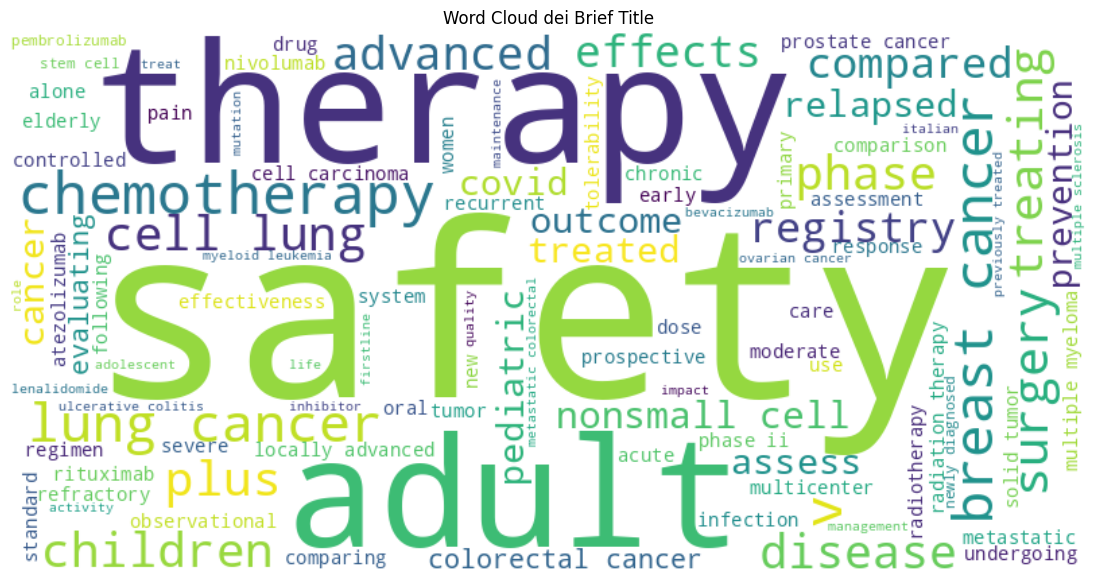

In [ ]:
from pyspark.sql.functions import concat_ws
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt

# Remove null values and concatenate the titles into a single string
briefTitlesDF = ctDS.select("Brief Title").na.drop()
briefTitles_RDD = briefTitlesDF.rdd.map(lambda row: row[0])
briefTitlesText = " ".join(briefTitles_RDD.collect())

# Text cleaning: Remove special characters, convert to lowercase, and eliminate stopwords
cleanedText = re.sub(r'[^A-Za-z\s]', '', briefTitlesText)
cleanedText = cleanedText.lower()

custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "patient", "patients", "study", "subject", "subjects", "clinical", "trial", "randomized", "placebo", "group", "efficacy", "treatment", "participant", "participants", "versus", "evaluate", "evaluation", "combination", "effect", "without"])

# Creating word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=custom_stopwords, max_words=100).generate(cleanedText)

# Visualization
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud dei Brief Title")
plt.show()

### [17] Funding organizations that collaborate most frequently with each other

In [ ]:
# Funding organizations that collaborate most frequently with each other
collabFunderDS = ctDS.filter(col("Funder Group").isNotNull() & col("Collaborating Funders").isNotNull()) \
    .withColumn("Main Funder", explode("Funder Group")) \
    .withColumn("Collaborating Funder", explode("Collaborating Funders")) \
    .filter(col("Main Funder") != col("Collaborating Funder")) \
    .groupBy("Main Funder", "Collaborating Funder") \
    .count()\
    .withColumnRenamed("count", "Number of Collaborations") \
    .orderBy(col("Number of Collaborations").desc())

collabFunderDS.show(20, truncate=False)

collabFunderResults = collabFunderDS.toPandas()
collabFunderResults.to_csv(os.path.join(resultsPath,"17_collabFunder.csv"))

+------------------------------------------------+----------------------------------------------------------+------------------------+
|Main Funder                                     |Collaborating Funder                                      |Number of Collaborations|
+------------------------------------------------+----------------------------------------------------------+------------------------+
|AMRC - Association of Medical Research Charities|European Organisation for Research and Treatment of Cancer|120                     |
|ICRP - International Cancer Research Partnership|National Cancer Institute                                 |116                     |
|US Federal Funders                              |National Cancer Institute                                 |116                     |
|NIH - National Institutes of Health             |National Cancer Institute                                 |116                     |
|EC & ERC - European Union                       |Europ

In [ ]:
# Funding Organizations with the Highest Mutual Collaboration (Top 1 Partnerships per Main Funder)
collabFunderPreDS = ctDS.filter(col("Funder Group").isNotNull() & col("Collaborating Funders").isNotNull()) \
    .withColumn("Main Funder", explode("Funder Group")) \
    .withColumn("Collaborating Funder", explode("Collaborating Funders")) \
    .filter(col("Main Funder") != col("Collaborating Funder")) \
    .groupBy("Main Funder", "Collaborating Funder") \
    .count()\
    .withColumnRenamed("count", "Number of Collaborations")

windowSpecCollab = Window.partitionBy("Main Funder").orderBy(col("Number of Collaborations").desc())

topCollaborators = collabFunderPreDS.withColumn("rank", row_number().over(windowSpecCollab)) \
              .filter(col("rank")==1) \
              .select("Main Funder", "Collaborating Funder", "Number of Collaborations") \
              .orderBy(col("Number of Collaborations").desc()) \

topCollaborators.show(truncate=False)

topCollaboratorsResults = topCollaborators.toPandas()
topCollaboratorsResults.to_csv(os.path.join(resultsPath,"17_topCollaborators.csv"))

+------------------------------------------------+----------------------------------------------------------+------------------------+
|Main Funder                                     |Collaborating Funder                                      |Number of Collaborations|
+------------------------------------------------+----------------------------------------------------------+------------------------+
|AMRC - Association of Medical Research Charities|European Organisation for Research and Treatment of Cancer|120                     |
|ICRP - International Cancer Research Partnership|National Cancer Institute                                 |116                     |
|NIH - National Institutes of Health             |National Cancer Institute                                 |116                     |
|US Federal Funders                              |National Cancer Institute                                 |116                     |
|EC & ERC - European Union                       |Europ